# Preambolo

In questo notebook condurrò una serie di attività:
1. Studiare gli effetti di variazioni nel parametro ccp_apha e dunque del Minimal Cost-Complexity Pruning sulla capacità dei DT di generalizzare e sulla loro struttura.

2. Utilizzare i risultati dello studio precedente per tentare di ricavare degli alberi di decisione non convoluti che realizzano classificazioni sulla base di regole ragionevoli e  coerenti con i risultati degli esperimenti precedenti.

3. Condurrò il seguente ersperimento: ripetutamente, indurrò 4 alberi di decisione (rispettivamente per realizzare la classificazione 3 vs All, 4 vs All,1 e 6 vs All e 0 (2 e 5) vs All) con hyper-parameters ottimizzati rispetto ad una data score e li fonderò insieme in un unico classificatore, la cui performance verrà valutata seocondo alcuni criteri. 

Per essere più specifici, in ciascuna ripetizione suddividerò il dataset in training set e test set (magari attraverso una StratifiedKFold). Il training set verrò utilizzato per indurre con gridsearchcv gli alberi di decisione sopracitati. Successivamente darò in input ai 3 alberi tutti i punti che per l'iterazione corrente costituiscono il test set e valuterò:

1. Quante volte un solo albero restituisce 1 come output (ovvero classifica il punto come appartenente alla classe che è stato allenato a riconoscere) e l'albero è effettivamente associato alla classe del punto in questione 
2. Quante volte due alberi restituiscono 1 come ouput a almeno uno dei due è associato all'effettiva classe del punto
3. Quante volte l'albero che associa al punto in input la maggiore probabilità di appartenere alla classe che è stato allenato a riconoscere appartiene effettivamente a tale classe 


## Valuto come il pruning influisce sulle performance dei DT e sulla loro "struttura" (numero di nodi, profondità, etc...) . L'obbiettivo è capire quale impatto potrebbe avere prendere in considerazione nel tuning l'hyper-parameter ccp_alpha e tantare di indurre dei DT ragionevoli
 
In aggiunta, devo: 
1. analizzare alcuni esperimenti vecchi (notebook 5) per capire l'impatto degli altri hyper parametri così da capire quali fissare e quali invece sono "degni" di subire variazioni nei processi di ottimizzazione.
2. determinare se le decisioni prese dagli alberi indotti sono coerenti con le feature importance ottenute negli esperimenti precedenti

## Moduli importati

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import graphviz

seed = 42

## Importo dataset

In [2]:
df = pd.read_excel('/home/sam/tirocinio/DB PAROTIDE DEF_corretto.xlsx', sheet_name='Sheet7')
df = df[df['ESCLUDERE'] == 0]
df = df.loc[:, ['Segni macro malignità', 'ADC', 'TIC type', 'T2', 'COD ISTO']]
df['ADC'] = df['ADC'].apply(lambda s: str(s).replace(',', '.')).astype(float)

#samples per cui la feature TIC type non è ancora stata sottoposta a one hot encoding

X_not_encoded = df.iloc[:,:-1].copy()

#samples sottoposti a one hot encoding

X_encoded = pd.get_dummies(X_not_encoded, columns = ['TIC type'])

y = df['COD ISTO'].copy()
y.value_counts()

3    53
4    27
1    12
5     6
2     5
6     4
Name: COD ISTO, dtype: int64

In [3]:
#separo test set e training set
#eseguo questa unica separazione iniziale
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size = 0.2,
                                                   random_state=seed, shuffle = True,
                                                   stratify = y)

## Studio complexity pruning 3 vs All

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

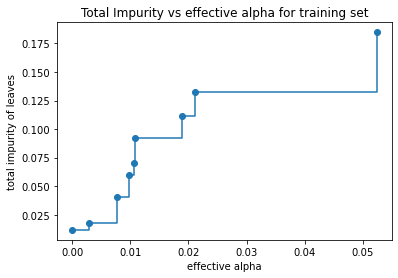

In [4]:
### 3 vs All

#creazione delle labels
y_bin_train_3 = [1 if x == 3 else 0 for x in y_train]
y_bin_test_3 = [1 if x == 3 else 0 for x in y_test]

clf = tree.DecisionTreeClassifier(random_state=seed)
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_bin_train_3)

#separo gli alpha dai valori delle impurità nelle foglie
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#desidero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
#rimuovo l'ultimo effective alpha perchè determina un pruning che porta ad avere un DT con un solo nodo
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [5]:
#ora alleno vari alberi usando gli effective alpha appena trovati, incluso l'ultimo, e stampo 
#l'ultimo effective alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_bin_train_3)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3151735334803179


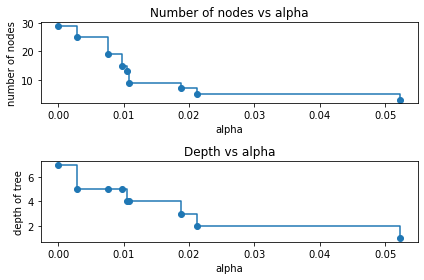

In [6]:
#ora rimuovo l'ultimo valore effective alpha perchè, come ho appena mostrato, conduce ad un albero costituito 
#da un solo nodo
#e mostro come il numero di nodi e la profondità variano al variare dei valori di alpha
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

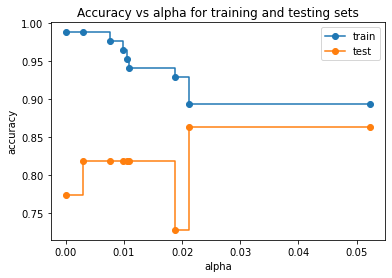

In [7]:
#ora studio come le performance variano al variare di alpha
#in questa cella uso mean accuracy
train_scores_meanacc = [clf.score(X_train, y_bin_train_3) for clf in clfs]
test_scores_meanacc = [clf.score(X_test, y_bin_test_3) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores_meanacc, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_meanacc, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

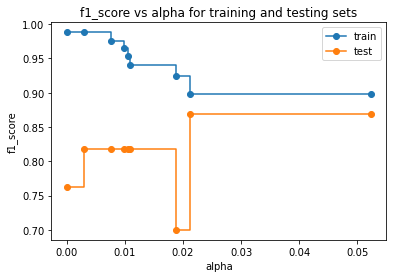

In [8]:
#qua uso f1_score

train_scores_f1 = [f1_score(y_bin_train_3, clf.predict(X_train)) for clf in clfs]
test_scores_f1 =[f1_score(y_bin_test_3, clf.predict(X_test)) for clf in clfs]
                 
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("f1_score")
ax.set_title("f1_score vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

plt.show()

In [9]:
#Da questi ultimi grafici noto come le massime performance sono raggiunte da un DT la cui profondità è stata
#ridotta a 3 o inferiore attraverso pruning

[Text(334.8, 226.5, 'ADC <= 1.075\ngini = 0.5\nsamples = 85\nvalue = [43, 42]\nclass = 0'),
 Text(167.4, 135.9, 'gini = 0.1\nsamples = 38\nvalue = [36, 2]\nclass = 0'),
 Text(502.20000000000005, 135.9, 'TIC type_A <= 0.5\ngini = 0.254\nsamples = 47\nvalue = [7, 40]\nclass = 1'),
 Text(334.8, 45.29999999999998, 'gini = 0.498\nsamples = 15\nvalue = [7, 8]\nclass = 1'),
 Text(669.6, 45.29999999999998, 'gini = 0.0\nsamples = 32\nvalue = [0, 32]\nclass = 1')]

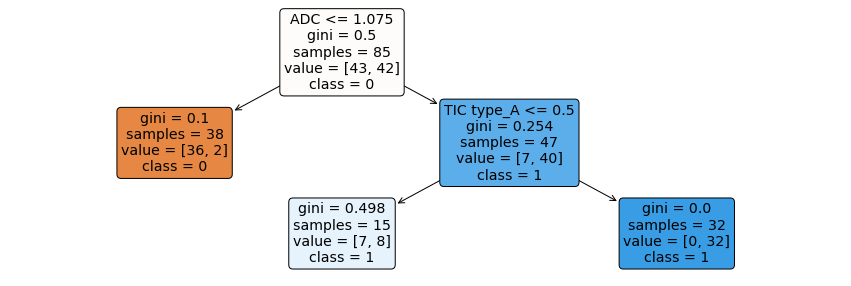

In [10]:
#Stampo ora l'albero 3 vs All che è caratterizzato dalla max performance-->scelgo f1_score
#Per essere più specifici, stampo l'albero di profondità non superiore a 3 con le migliori performance sul test
#set

indexes = np.where([True if x <= 3 else False for x in depth])[0]

three_vs_all = clfs[(pd.Series(test_scores_f1)[indexes]).idxmax()]

fig = plt.figure(figsize=(15,5))
tree.plot_tree(clfs[(pd.Series(test_scores_f1)[indexes]).idxmax()],
               feature_names = X_encoded.columns,
               class_names = ['0','1'], filled = True, rounded = True)


In [11]:
#Quest'albero è coerente con l'importanza delle feature per la classificazione 3 vs All estratta nel notebook 
#precdente, e non appare convoluto. Sono dunque confidente, anche alla luce dei sovrastanti grafici, che abbia una
#buona capacità di generalizzazione

In [12]:
print('f1_score: %0.3f' %(max(pd.Series(test_scores_f1)[indexes])))

f1_score: 0.870


In [13]:
#stampo lo specifico valore di alpha che ha portato a questo pruning
print("Printed tree's ccp_alpha: %0.5f " %(ccp_alphas[(pd.Series(test_scores_f1)[indexes]).idxmax()]))

Printed tree's ccp_alpha: 0.02118 


## Studio complexity pruning 4 vs All

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

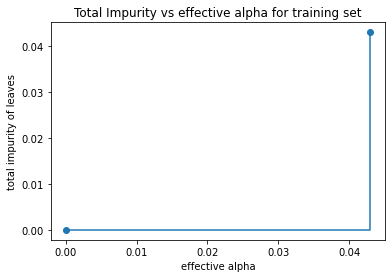

In [14]:
#4 vs all

#creazione delle labels
y_bin_train_4 = [1 if x == 4 else 0 for x in y_train]
y_bin_test_4 = [1 if x == 4 else 0 for x in y_test]


clf = tree.DecisionTreeClassifier(random_state=seed)
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_bin_train_4)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#deisdero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
#rimuovo l'ultimo effective alpha perchè corrisponde al DT con un solo nodo
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3290747705731909


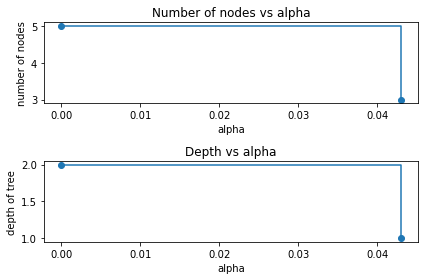

In [15]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_bin_train_4)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

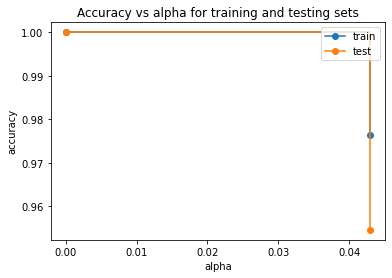

In [16]:
train_scores_meanacc = [clf.score(X_train, y_bin_train_4) for clf in clfs]
test_scores_meanacc = [clf.score(X_test, y_bin_test_4) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores_meanacc, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_meanacc, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

plt.show()

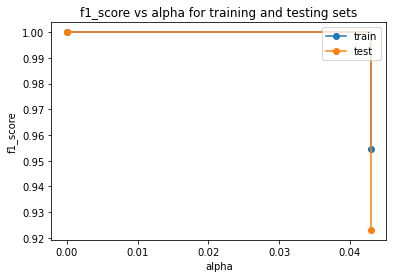

In [17]:
train_scores_f1 = [f1_score(y_bin_train_4, clf.predict(X_train)) for clf in clfs]
test_scores_f1 =[f1_score(y_bin_test_4, clf.predict(X_test)) for clf in clfs]
                 
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("f1_score")
ax.set_title("f1_score vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

plt.show()

In [18]:
#Cosa deduco per 4 vs All?
#Deduco che le massime performance si ottengono già con l'albero di default, senza applicare alcun pruning
#ottengo già un albero compatto ottimale

[Text(334.8, 226.5, 'TIC type_B <= 0.5\ngini = 0.372\nsamples = 85\nvalue = [64, 21]\nclass = 0'),
 Text(167.4, 135.9, 'gini = 0.0\nsamples = 62\nvalue = [62, 0]\nclass = 0'),
 Text(502.20000000000005, 135.9, 'ADC <= 0.6\ngini = 0.159\nsamples = 23\nvalue = [2, 21]\nclass = 1'),
 Text(334.8, 45.29999999999998, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = 0'),
 Text(669.6, 45.29999999999998, 'gini = 0.0\nsamples = 21\nvalue = [0, 21]\nclass = 1')]

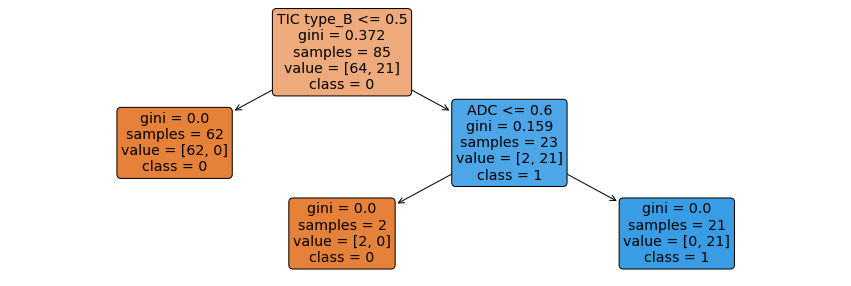

In [19]:
indexes = np.where([True if x <= 3 else False for x in depth])[0]

four_vs_all = clfs[(pd.Series(test_scores_f1)[indexes]).idxmax()]

fig = plt.figure(figsize=(15,5))
tree.plot_tree(clfs[(pd.Series(test_scores_f1)[indexes]).idxmax()],
               feature_names = X_encoded.columns,
               class_names = ['0','1'], filled = True, rounded = True)

In [20]:
#anche in questo caso, l'albero ottenuto è coerente con i risultati ottenuti nel notebook precedente riguardo la
#classificazione 4 vs All

In [21]:
print('f1_score: %0.3f' %(max(pd.Series(test_scores_f1)[indexes])))

f1_score: 1.000


In [22]:
print("Printed tree's ccp_alpha: %0.5f " %(ccp_alphas[(pd.Series(test_scores_f1)[indexes]).idxmax()]))

Printed tree's ccp_alpha: 0.00000 


# Ripeto ciò che ho fatto per 3 vs All e 4 vs All senza considerare la feature 'Segni macro malignità'

In [23]:
X_train_prova = X_train.copy().drop(['Segni macro malignità'], axis = 1)
X_test_prova = X_test.copy().drop(['Segni macro malignità'], axis = 1)

[Text(334.8, 226.5, 'ADC <= 1.075\ngini = 0.5\nsamples = 85\nvalue = [43, 42]\nclass = 0'),
 Text(167.4, 135.9, 'gini = 0.1\nsamples = 38\nvalue = [36, 2]\nclass = 0'),
 Text(502.20000000000005, 135.9, 'TIC type_A <= 0.5\ngini = 0.254\nsamples = 47\nvalue = [7, 40]\nclass = 1'),
 Text(334.8, 45.29999999999998, 'gini = 0.498\nsamples = 15\nvalue = [7, 8]\nclass = 1'),
 Text(669.6, 45.29999999999998, 'gini = 0.0\nsamples = 32\nvalue = [0, 32]\nclass = 1')]

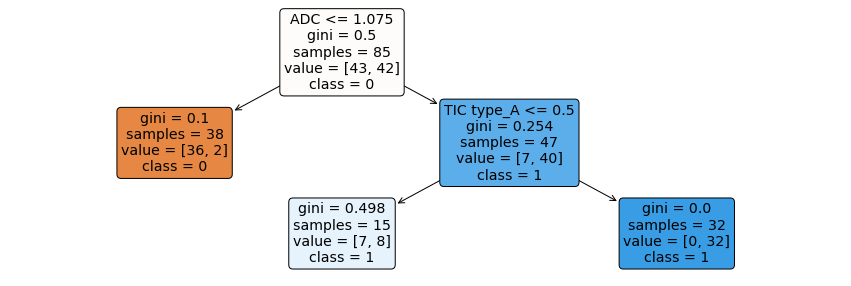

In [24]:
#3 vs All


clf = tree.DecisionTreeClassifier(random_state=seed)
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train_prova, y_bin_train_3)

#separo gli alpha dai valori delle impurità nelle foglie
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train_prova, y_bin_train_3)
    clfs.append(clf)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]


train_scores_f1 = [f1_score(y_bin_train_3, clf.predict(X_train_prova)) for clf in clfs]
test_scores_f1 =[f1_score(y_bin_test_3, clf.predict(X_test_prova)) for clf in clfs]
                 
indexes = np.where([True if x <= 3 else False for x in depth])[0]


fig = plt.figure(figsize=(15,5))
tree.plot_tree(clfs[(pd.Series(test_scores_f1)[indexes]).idxmax()],
               feature_names = X_train_prova.columns,
               class_names = ['0','1'], filled = True, rounded = True)



[Text(334.8, 226.5, 'TIC type_B <= 0.5\ngini = 0.372\nsamples = 85\nvalue = [64, 21]\nclass = 0'),
 Text(167.4, 135.9, 'gini = 0.0\nsamples = 62\nvalue = [62, 0]\nclass = 0'),
 Text(502.20000000000005, 135.9, 'ADC <= 0.6\ngini = 0.159\nsamples = 23\nvalue = [2, 21]\nclass = 1'),
 Text(334.8, 45.29999999999998, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]\nclass = 0'),
 Text(669.6, 45.29999999999998, 'gini = 0.0\nsamples = 21\nvalue = [0, 21]\nclass = 1')]

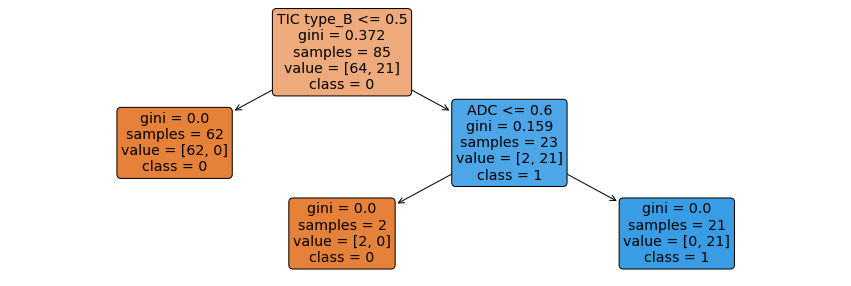

In [25]:
#4 vs all

#creazione delle labels
y_bin_train_4 = [1 if x == 4 else 0 for x in y_train]
y_bin_test_4 = [1 if x == 4 else 0 for x in y_test]


clf = tree.DecisionTreeClassifier(random_state=seed)
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_bin_train_4)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train_prova, y_bin_train_4)
    clfs.append(clf)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

depth = [clf.tree_.max_depth for clf in clfs]

test_scores_f1 =[f1_score(y_bin_test_4, clf.predict(X_test_prova)) for clf in clfs]

indexes = np.where([True if x <= 3 else False for x in depth])[0]

fig = plt.figure(figsize=(15,5))
tree.plot_tree(clfs[(pd.Series(test_scores_f1)[indexes]).idxmax()],
               feature_names = X_train_prova.columns,
               class_names = ['0','1'], filled = True, rounded = True)
                 


## Studio pruning per 1 e 6 vs All

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

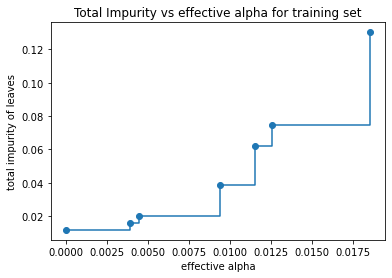

In [26]:
# 1 e 6 vs all

 
y_bin_train_16 = [1 if x in (1,6) else 0 for x in y_train]
y_bin_test_16 = [1 if x in (1,6) else 0 for x in y_test]
    
clf = tree.DecisionTreeClassifier(random_state=seed)
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_bin_train_16)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#deisdero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
#rimuovo l'ultimo effective alpha perchè corrisponde al DT con un solo nodo
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")


Number of nodes in the last tree is: 1 with ccp_alpha: 0.12878360393931335


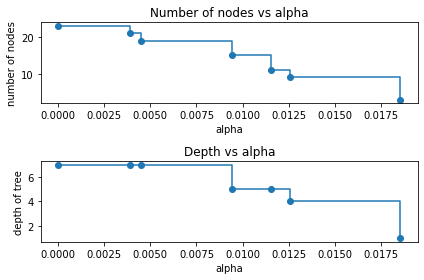

In [27]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_bin_train_16)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

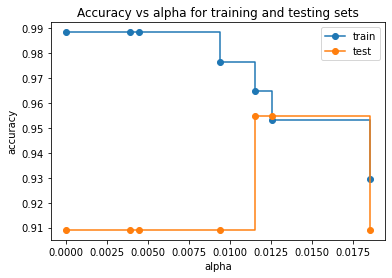

In [28]:
train_scores_meanacc = [clf.score(X_train, y_bin_train_16) for clf in clfs]
test_scores_meanacc = [clf.score(X_test, y_bin_test_16) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores_meanacc, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_meanacc, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

plt.show()

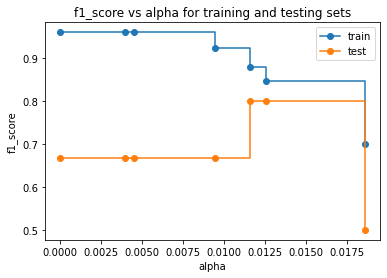

In [29]:
train_scores_f1 = [f1_score(y_bin_train_16, clf.predict(X_train)) for clf in clfs]
test_scores_f1 =[f1_score(y_bin_test_16, clf.predict(X_test)) for clf in clfs]
                 
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("f1_score")
ax.set_title("f1_score vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

plt.show()

In [30]:
#per 1 e 6 vs All deduco che le migliori performance si hanno per valori di alpha superiori a 0.0125 circa e 
#queste collassano per alpha > 0.0175 circa
#tuttativa alzare il valore di alpha fino a ridurre la profondità a  3 o infeiore fa colare a picco le performance
#e porta ad un albero con un solo nodo
#dunque ritengo che l'approccio migliore sia accontantarsi di un albero di profondità 4 e prendersi quello con
#le migliori performance

[Text(502.20000000000005, 244.62, 'Segni macro malignità <= 0.5\ngini = 0.259\nsamples = 85\nvalue = [72, 13]\nclass = 0'),
 Text(334.8, 190.26000000000002, 'TIC type_C <= 0.5\ngini = 0.142\nsamples = 78\nvalue = [72, 6]\nclass = 0'),
 Text(167.4, 135.9, 'gini = 0.034\nsamples = 57\nvalue = [56, 1]\nclass = 0'),
 Text(502.20000000000005, 135.9, 'ADC <= 1.275\ngini = 0.363\nsamples = 21\nvalue = [16, 5]\nclass = 0'),
 Text(334.8, 81.54000000000002, 'T2 <= 0.5\ngini = 0.473\nsamples = 13\nvalue = [8, 5]\nclass = 0'),
 Text(167.4, 27.180000000000007, 'gini = 0.245\nsamples = 7\nvalue = [6, 1]\nclass = 0'),
 Text(502.20000000000005, 27.180000000000007, 'gini = 0.444\nsamples = 6\nvalue = [2, 4]\nclass = 1'),
 Text(669.6, 81.54000000000002, 'gini = 0.0\nsamples = 8\nvalue = [8, 0]\nclass = 0'),
 Text(669.6, 190.26000000000002, 'gini = 0.0\nsamples = 7\nvalue = [0, 7]\nclass = 1')]

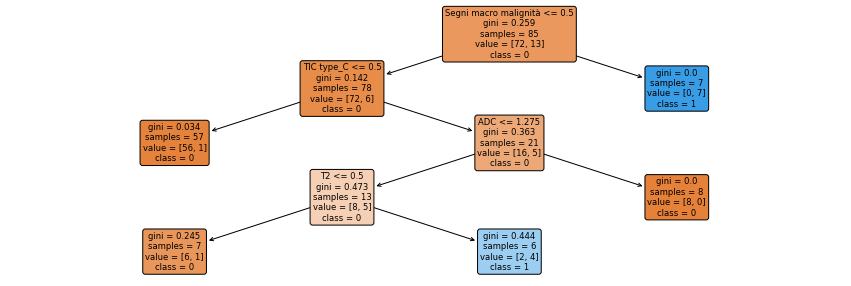

In [31]:
#alzo la profondità  a 4 qui
indexes = np.where([True if x <= 4 else False for x in depth])[0]

onesix_vs_all = clfs[(pd.Series(test_scores_f1)[indexes]).idxmax()]

fig = plt.figure(figsize=(15,5))
tree.plot_tree(clfs[(pd.Series(test_scores_f1)[indexes]).idxmax()],
               feature_names = X_encoded.columns,
               class_names = ['0','1'], filled = True, rounded = True)

In [32]:
#nel caso della classificazione 1 e 6 vs All è un po' più difficile stabilire se questo albero è coerente con 
#l'importanza delle feature perchè queste non erano molto omogonee, ma credo di poter affermare che vi è una 
#coincidenza singificativa

In [33]:
print('f1_score: %0.3f' %(max(pd.Series(test_scores_f1)[indexes])))

f1_score: 0.800


In [34]:
print("Printed tree's ccp_alpha: %0.5f " %(ccp_alphas[(pd.Series(test_scores_f1)[indexes]).idxmax()]))

Printed tree's ccp_alpha: 0.01255 


### Per omogeneità, compio lo stesso studio per classificare i tumori 2 e 5 --> other (0)

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

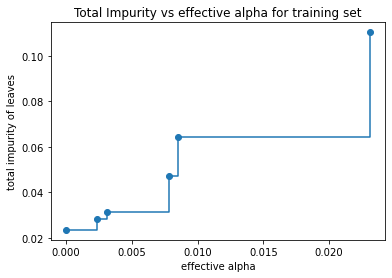

In [35]:
#2 e 5 vs All

 
y_bin_train_0 = [1 if x in (2,5) else 0 for x in y_train]
y_bin_test_0 = [1 if x in (2,5) else 0 for x in y_test]
    
clf = tree.DecisionTreeClassifier(random_state=seed)
#path che contiene gli alpha e le impurità in ciascuno step del processo di pruning
path = clf.cost_complexity_pruning_path(X_train, y_bin_train_0)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

#deisdero visualizzare come nella classificazione 3 vs All le impurità crescono con il crescere di alpha
fig, ax = plt.subplots()
#rimuovo l'ultimo effective alpha perchè corrisponde al DT con un solo nodo
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")


Number of nodes in the last tree is: 1 with ccp_alpha: 0.07895766585501299


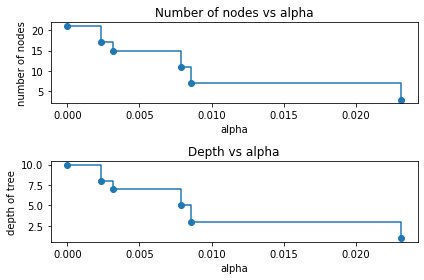

In [36]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=seed, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_bin_train_0)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

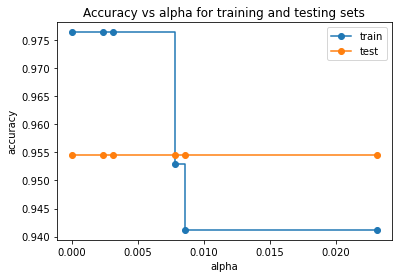

In [37]:
train_scores_meanacc = [clf.score(X_train, y_bin_train_0) for clf in clfs]
test_scores_meanacc = [clf.score(X_test, y_bin_test_0) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores_meanacc, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_meanacc, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

plt.show()

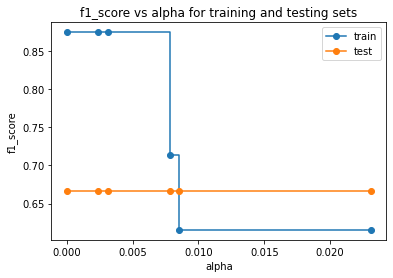

In [38]:
train_scores_f1 = [f1_score(y_bin_train_0, clf.predict(X_train)) for clf in clfs]
test_scores_f1 =[f1_score(y_bin_test_0, clf.predict(X_test)) for clf in clfs]
                 
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("f1_score")
ax.set_title("f1_score vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores_f1, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores_f1, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()

plt.show()

[Text(418.5, 203.85000000000002, 'ADC <= 0.6\ngini = 0.189\nsamples = 85\nvalue = [76, 9]\nclass = 0'),
 Text(209.25, 67.94999999999999, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = 1'),
 Text(627.75, 67.94999999999999, 'gini = 0.116\nsamples = 81\nvalue = [76, 5]\nclass = 0')]

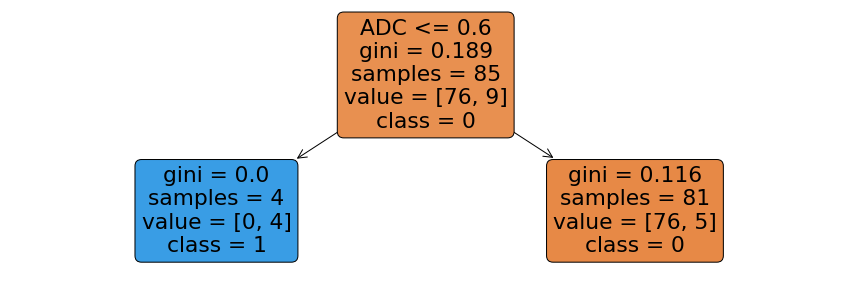

In [39]:
#provo a vedere con profondità 1
indexes = np.where([True if x <= 1 else False for x in depth])[0]

zero_vs_all = clfs[(pd.Series(test_scores_f1)[indexes]).idxmax()]

fig = plt.figure(figsize=(15,5))
tree.plot_tree(clfs[(pd.Series(test_scores_f1)[indexes]).idxmax()],
               feature_names = X_encoded.columns,
               class_names = ['0','1'], filled = True, rounded = True)

In [40]:
#non è particolarmente illuminante

In [41]:
print('f1_score: %0.3f' %(max(pd.Series(test_scores_f1)[indexes])))

f1_score: 0.667


In [42]:
print("Printed tree's ccp_alpha: %0.5f " %(ccp_alphas[(pd.Series(test_scores_f1)[indexes]).idxmax()]))

Printed tree's ccp_alpha: 0.02311 


 # Ora faccio il merge dei 4 alberi appena ottenuti per vedere se ottengo delle performance migliori dei singoli DT
 
Successivamente a questa prova automatizzerò il processo così da poter ottenere degli indici numerici che esprimano le performance in media mediamente facendo un merge di questo tipo

In [43]:

from sklearn.metrics import classification_report

def raw_merge(X, y, clfs):

    map_dict = {0:0,1:1,2:3,3:4}
    mapping = lambda n : map_dict[n]

    
    apply_dict = {1:1,2:0,3:3,4:4,5:0, 6:1}
    applyf = lambda n : apply_dict[n]
    
    y = list(y.apply(applyf))

    outputs = np.zeros((len(clfs), len(X)))
    prob_outputs = np.zeros((len(clfs), len(X)))
    

    for enum, clf in enumerate(clfs):
        outputs[enum] = clf.predict(X)
        prob_outputs[enum] = clf.predict_proba(X).T[1]
    
    #samples vs 0,1,2,3
    outputs = np.transpose(outputs)
    prob_outputs = np.transpose(prob_outputs)
    
    #lista di labels, senza None
    max_prob_labels = [mapping(np.argmax(x)) for x in prob_outputs]
    
    
    #lista di triple di labels-->da modificare
    #max_2prob_labels = [[mapping(index) for index, k in enumerate(x) if k > min(x) ] for x in prob_outputs]
    
    #lista di labels, con eventuali None per indicare che vi è stato più di un 1 o nessuno
    single_one_labels = [mapping(np.argmax(x)) if sum(x) == 1 else None for x in outputs]
    
    #lista di coppie di labels, con eventuali None per indicare che ho ottenuto due uno
    double_one_labels = [[mapping(index) for index, k in enumerate(x) if k==1] if sum(x) in (1,2) else [] for x in outputs]
    

    single_one_correct = sum([1 if y[enum] == x else 0 for enum, x in enumerate(single_one_labels)])
    double_one_correct = sum([1 if y[enum] in x else 0 for enum, x in enumerate(double_one_labels)])
    max_prob_correct = sum([1 if y[enum] == x else 0 for enum, x in enumerate(max_prob_labels)])

    
   
    #stampo performance
    print('### RESULTS ###')
    print('Test set size: %d' %(len(X)))
    print('single_one_correct: %d' %(single_one_correct))
    print('double_one_correct: %d' %(double_one_correct))
    print('max_prob_correct: %d' %(max_prob_correct))
    print('Classification report probability:')
    print(classification_report(y, max_prob_labels))



In [44]:
clfs = [zero_vs_all, onesix_vs_all, three_vs_all, four_vs_all]
raw_merge(X_test, y_test, clfs)

### RESULTS ###
Test set size: 22
single_one_correct: 19
double_one_correct: 19
max_prob_correct: 19
Classification report probability:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       1.00      0.67      0.80         3
           3       0.83      0.91      0.87        11
           4       1.00      1.00      1.00         6

    accuracy                           0.86        22
   macro avg       0.83      0.77      0.79        22
weighted avg       0.87      0.86      0.86        22



## Ora che ho condotto degli esperimenti è il momento di automatizzare questo processo 

In [45]:
#labels:
# 0-->(2,5)
# 1-->(1,6)
# 3-->(3)
# 4-->(4)

#tuned parameters è un dict che associa a ciascun label i parametri su cui voglio fare basare l'ottimizzazione

#decido di giocare sulla profondità, non sul pruning


def foo(X, y, tuned_parameters, scoring_func = accuracy_score, n_splits = 4, n_splits_gs = 3,
       n_it = 10, random_state_tree = None):
    
    #Alcuni preliminari
    
    #funzione che mappa le labels originarie alle label funzionali alla classificazione
    #comoda
    tolabel_dict = {1:1,2:0,3:3,4:4,5:0,6:1}
    tolabelf = lambda n : tolabel_dict[n]
    
    #dalle label della classificazione alle label originarie
    #lo creo solo per facilitarmi la vita
    reverselabel_dict = {0:(2,5), 1:(1,6), 3:(3,), 4:(4,)}
    reverselabelf = lambda n: reverselabel_dict[n]
    
    #tupla che uso solo per fissare un ordine alle label quando manipolo le classificazioni
    labels = (0,1,3,4)
    
    #utile quando manipolo le classificazioni
    map_dict = {0:0,1:1,2:3,3:4}
    mapping = lambda n : map_dict[n]
    
    #--------------------------------------------------------------------------------------------------------
    
    #creazione scorer da usare per la gridsearchcv
    scoring = make_scorer(scoring_func)
    
    
    for it in range(n_it):
        print('### ITERATION %d ###\n' %(it+1))
        
        skf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = None)
        
        scores = []
        
        for train_index, test_index in skf.split(X, y):
            
            #creo test set e training set
            #magari pensa di usare degli array
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            
            #creo le labels
            y_train_dict = {}

            for label in labels:
                y_train_dict[label] = [1 if x in reverselabel_dict[label] else 0 for x in y_train] 
                
            
            y_test = list(y_test.apply(tolabelf))
        
            #oggetto da usare per la inner GridSearchCv
            cv = StratifiedKFold(n_splits = n_splits_gs, shuffle = True, random_state = None)
            
            optimal_trees = {}
            
            for label in labels:
                
                print('# Training DT %d vs All #' %(label))
                
                albero = tree.DecisionTreeClassifier(random_state = random_state_tree)
                
                clf_gs = GridSearchCV(albero, param_grid = tuned_parameters[label], cv = cv, scoring = scoring,
                              refit = True)
                
                clf_gs.fit(X_train, y_train_dict[label])

                print('Parameters found for DT %d vs All: ' %(label) )
                print(clf_gs.best_params_)
                print('Average cross-validated score of best_estimator_ %d vs All: %0.3f\n\n' %(label, clf_gs.best_score_))
                optimal_trees[label] = clf_gs.best_estimator_
                
            
            #trovati gli alberi ottimali, messi in optimal_trees
            print('## Merge of DTs and performance evaluation ##')
            
                
            outputs = np.zeros((len(optimal_trees), len(X_test)))
            prob_outputs = np.zeros((len(optimal_trees), len(X_test)))


            for enum, label in enumerate(labels):
                outputs[enum] = optimal_trees[label].predict(X_test)
                prob_outputs[enum] = optimal_trees[label].predict_proba(X_test).T[1]

            #samples vs 0,1,2,3
            outputs = np.transpose(outputs)
            prob_outputs = np.transpose(prob_outputs)

            #lista di labels, priva di None di sicuro
            max_prob_labels = [mapping(np.argmax(x)) for x in prob_outputs]
            
            #lista di labels, con eventuali None per indicare che vi è stato più di un 1 o nessun 1
        
            single_one_labels = [mapping(np.argmax(x)) if sum(x) == 1 else None for x in outputs]
            


            #lista di coppie di labels, con eventuali liste vuote per indicare che ho ottenuto più di due uno
            double_one_labels = [[mapping(index) for index, k in enumerate(x) if k==1] if sum(x) in (1,2) else []  for x in outputs]


            single_one_correct = sum([1 if y_test[enum] == x else 0 for enum, x in enumerate(single_one_labels)])
            double_one_correct = sum([1 if y_test[enum] in x else 0 for enum, x in enumerate(double_one_labels)])
            max_prob_correct = sum([1 if y_test[enum] == x else 0 for enum, x in enumerate(max_prob_labels)])

            #stampo performance
            print('## RESULTS ##')
            print('Test set size: %d' %(len(X_test)))
            print('single_one_correct: %d' %(single_one_correct))
            print('double_one_correct: %d' %(double_one_correct))
            print('max_prob_correct: %d' %(max_prob_correct))
            print('Classification report for probabilities:')
            print(classification_report(y_test, max_prob_labels, zero_division = 0))
            if scoring_func is f1_score:
                scores.append(f1_score(y_test, max_prob_labels, average = 'weighted'))
            else:
                scores.append(scoring_func(y_test, max_prob_labels))

            print('-<>-'*20)
        print('## Average performance current iteration ##')
        print('Mean score: %0.3f' %(np.mean(scores)))
        print('Std deviation: %0.3f' %(np.std(scores)))

In [46]:
tuned_parameters = {0: {'max_depth':[2,3,4]},
                    1: {'max_depth':[2,3,4]},
                    3: {'max_depth':[2,3,4]},
                    4: {'max_depth':[2,3,4]},
                    }


seed = 42

# Ottimizzo per accuracy

In [47]:
foo(X_encoded, y, tuned_parameters, random_state_tree = None, n_it = 1 )

### ITERATION 1 ###

# Training DT 0 vs All #
Parameters found for DT 0 vs All: 
{'max_depth': 2}
Average cross-validated score of best_estimator_ 0 vs All: 0.938


# Training DT 1 vs All #
Parameters found for DT 1 vs All: 
{'max_depth': 3}
Average cross-validated score of best_estimator_ 1 vs All: 0.937


# Training DT 3 vs All #
Parameters found for DT 3 vs All: 
{'max_depth': 3}
Average cross-validated score of best_estimator_ 3 vs All: 0.850


# Training DT 4 vs All #
Parameters found for DT 4 vs All: 
{'max_depth': 2}
Average cross-validated score of best_estimator_ 4 vs All: 1.000


## Merge of DTs and performance evaluation ##
## RESULTS ##
Test set size: 27
single_one_correct: 19
double_one_correct: 22
max_prob_correct: 22
Classification report for probabilities:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       0.43      0.75      0.55         4
           3       0.91      0.71      0.80        14


# Ottimizzo per f1_score

In [48]:
foo(X_encoded, y, tuned_parameters, random_state_tree = None, n_it = 1, scoring_func = f1_score)

### ITERATION 1 ###

# Training DT 0 vs All #
Parameters found for DT 0 vs All: 
{'max_depth': 2}
Average cross-validated score of best_estimator_ 0 vs All: 0.489


# Training DT 1 vs All #
Parameters found for DT 1 vs All: 
{'max_depth': 4}
Average cross-validated score of best_estimator_ 1 vs All: 0.635


# Training DT 3 vs All #
Parameters found for DT 3 vs All: 
{'max_depth': 2}
Average cross-validated score of best_estimator_ 3 vs All: 0.875


# Training DT 4 vs All #
Parameters found for DT 4 vs All: 
{'max_depth': 2}
Average cross-validated score of best_estimator_ 4 vs All: 1.000


## Merge of DTs and performance evaluation ##
## RESULTS ##
Test set size: 27
single_one_correct: 22
double_one_correct: 24
max_prob_correct: 25
Classification report for probabilities:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.75      0.86         4
           3       0.93      0.93      0.93        14


# Conclusioni + confronto con gli esperimenti precedenti
Eseguire questo merge ha portato a performance globali migliori, ma non particolarmente migliori, di quelle ottenute inducendo direttamente un albero che fosse in grado di eseguire la classificazione multiclasse